In [1]:
from fastai.vision import *

In [2]:
path=Path('data/bears')

In [3]:
folder='black'
file='black.csv'

In [10]:
folder='teddy'
file='teddy.csv'

In [13]:
folder='grizzly'
file='grizzly.csv'

In [4]:
dest=path/folder
dest.mkdir(parents=True,exist_ok=True)

In [15]:
download_images(path/file,dest,max_pics=200)

In [16]:
classes=['grizzly','teddy','black']

In [17]:
! pip install webp

In [18]:
! python -m pip install Pillow

In [19]:
for c in classes:
    print(c)
    verify_images(path/c,delete=True,max_size=400)

grizzly


image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
cannot identify image file <_io.BufferedReader name='data/bears/grizzly/00000196.jpg'>
image file could not be identified because WEBP support not installed
teddy


image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed


/opt/conda/envs/fastai/lib/python3.6/site-packages/PIL/Image.py:1022: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
image file could not be identified because WEBP support not installed
black


image file could not be identified because WEBP support not installed
cannot identify image file <_io.BufferedReader name='data/bears/black/00000170.jpg'>
data/bears/black/00000106.JPG: Removing corrupt EXIF data


/opt/conda/envs/fastai/lib/python3.6/site-packages/PIL/Image.py:1022: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


cannot identify image file <_io.BufferedReader name='data/bears/black/00000137.jpg'>
image file could not be identified because WEBP support not installed


In [214]:
doc(ImageDataBunch)

In [20]:
random.seed(4)
data=ImageDataBunch.from_folder(path,
                                train='.',
                                valid_pct=.2,
                                size=224,
                                bs=64,
                                ds_tfms=get_transforms()
                               ).normalize(imagenet_stats)

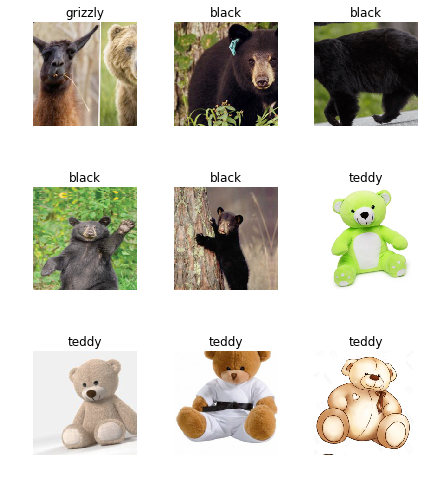

In [24]:
data.show_batch(rows=3,figsize=(6,7))

In [21]:
learner=cnn_learner(data,models.resnet34,metrics=error_rate)

In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-04
Min loss divided by 10: 1.20E-02


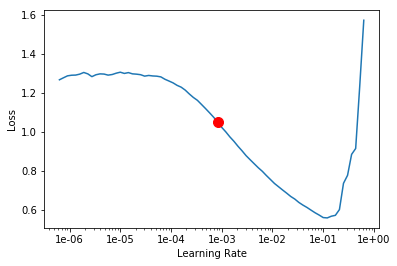

In [23]:
learner.recorder.plot(suggestion=True,skip_end=True)

In [25]:
learner.fit_one_cycle(4,8.32E-04)

epoch,train_loss,valid_loss,error_rate,time
0,1.069245,0.627360,0.339286,00:06
1,0.699464,0.210383,0.071429,00:05
2,0.489904,0.181314,0.071429,00:05
3,0.379210,0.172065,0.062500,00:05


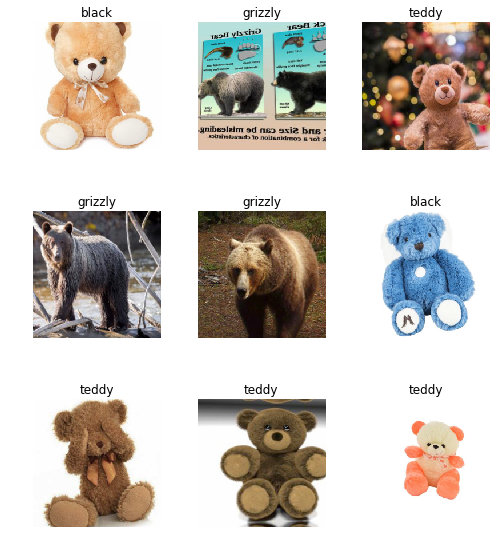

In [210]:
data.show_batch(rows=3, figsize=(7,8))

In [18]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddy'], 3, 452, 112)

In [19]:
learner.save('stage-1')

In [20]:
learner.unfreeze()

In [21]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-05
Min loss divided by 10: 9.12E-04


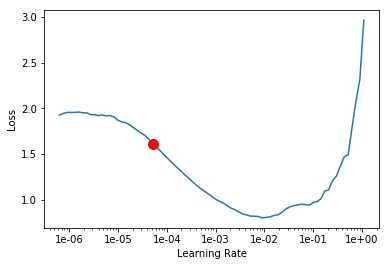

In [22]:
learner.recorder.plot(suggestion=True,skip_end=True)

In [23]:
learner.fit_one_cycle(4,max_lr=slice(5.25E-05,8.32E-05))

epoch,train_loss,valid_loss,error_rate,time
0,1.839767,0.807489,0.383929,00:04
1,1.208336,0.182654,0.089286,00:04
2,0.840162,0.135634,0.062500,00:04
3,0.646888,0.134582,0.053571,00:04


In [24]:
learner.save('stage-2')

In [25]:
intrep=ClassificationInterpretation.from_learner(learner)

In [26]:
intrep.most_confused()

[('black', 'grizzly', 3), ('grizzly', 'black', 3)]

In [27]:
from fastai.widgets import *

In [28]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [29]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [30]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)


In [31]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [32]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [33]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [35]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_by_rand_pct()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=64)
     )

In [40]:
len(db.valid_ds)

111

In [41]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [43]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 1.58E-03


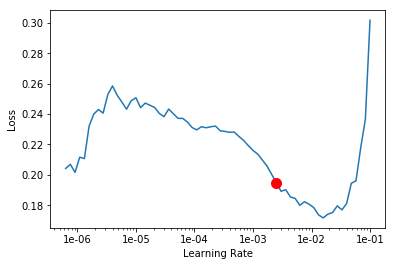

In [45]:
learn_cln.recorder.plot(suggestion=True)

In [46]:
learn_cln.fit_one_cycle(4,2.51E-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.212982,0.125005,0.027027,00:04
1,0.190881,0.141728,0.045045,00:03
2,0.182813,0.123392,0.036036,00:03
3,0.148008,0.093965,0.036036,00:03


In [47]:
learn_cln.fit_one_cycle(10,2.51E-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.051274,0.093169,0.036036,00:03
1,0.051481,0.100661,0.027027,00:03
2,0.063274,0.133591,0.054054,00:03
3,0.055782,0.117047,0.054054,00:04
4,0.056414,0.131130,0.036036,00:03
5,0.052758,0.127606,0.036036,00:03
6,0.065024,0.127439,0.018018,00:03
7,0.055353,0.124188,0.018018,00:04
8,0.052921,0.122735,0.018018,00:03
9,0.049898,0.120226,0.018018,00:03


In [48]:
learn_cln.save('stage-cleaned')

In [49]:
learn_cln.unfreeze()

In [50]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.91E-07


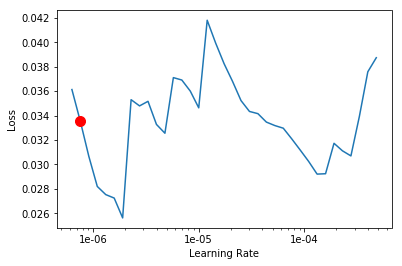

In [51]:
learn_cln.recorder.plot(suggestion=True)

In [52]:
learn_cln.fit_one_cycle(4,max_lr=slice(7.59E-07,2.51E-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.093228,0.119714,0.018018,00:04
1,0.061729,0.131165,0.027027,00:04
2,0.045789,0.139404,0.036036,00:04
3,0.033591,0.138428,0.036036,00:04


In [54]:
learn_cln=learn_cln.load('stage-cleaned')

In [55]:
learn_cln.freeze()

In [59]:
learn_cln.export('bears-classsifier.pkl')

In [61]:
bears=load_learner(path,'bears-classsifier.pkl')

img=open_image(path/'black'/'00000007.jpg')

bears.predict(img)

# size=512

In [70]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_by_rand_pct()
                   .label_from_df()
                   .transform(get_transforms(), size=512)
                   .databunch(bs=16)
     ).normalize(imagenet_stats)

In [72]:
learn_cln.data=db

In [74]:
learn_cln.freeze()

In [75]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-04


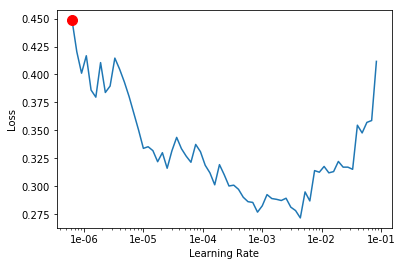

In [76]:
learn_cln.recorder.plot(suggestion=True)

In [77]:
learn_cln.fit_one_cycle(4,7e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.343742,0.023886,0.009009,00:09
1,0.332034,0.042050,0.018018,00:09
2,0.328312,0.024255,0.009009,00:09
3,0.342880,0.041682,0.009009,00:09


In [78]:
learn_cln.save('stage-1-learn_cln-512')

In [79]:
learn_cln.unfreeze()

In [80]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.74E-06


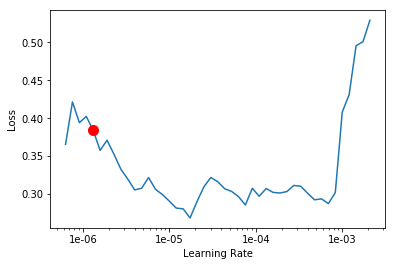

In [81]:
learn_cln.recorder.plot(suggestion=True)

In [82]:
learn_cln.fit_one_cycle(4,max_lr=slice(2e-6,(7e-6)/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.269984,0.026980,0.009009,00:11
1,0.379852,0.024659,0.009009,00:11
2,0.325328,0.032116,0.009009,00:11
3,0.305494,0.030665,0.009009,00:11
